# K210从训练到部署实战

## 0. 导入必要的库

In [101]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import numpy as np

# 若检测到有GPU则使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. 参数设置

In [102]:
# 超参数设置
epochs = 5
batch_size_train = 64
batch_size_test = 64
lr = 0.01
momentum = 0.5

# 训练配置
num_workers = 12
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

## 2. 准备数据集

In [103]:
train_dataloader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Resize(224),
                      transforms.Normalize((0.1307,),(0.3081,))
                  ])),
    batch_size=batch_size_train, shuffle=True, num_workers=num_workers
)
test_dataloader = DataLoader(
    datasets.MNIST('../data', train=False, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Resize(224),
                      transforms.Normalize((0.1307,),(0.3081,))
                  ])),
    batch_size=batch_size_test, shuffle=True, num_workers=num_workers
)

### 2.1 数据集可视化

torch.Size([64])
torch.Size([64, 1, 224, 224])


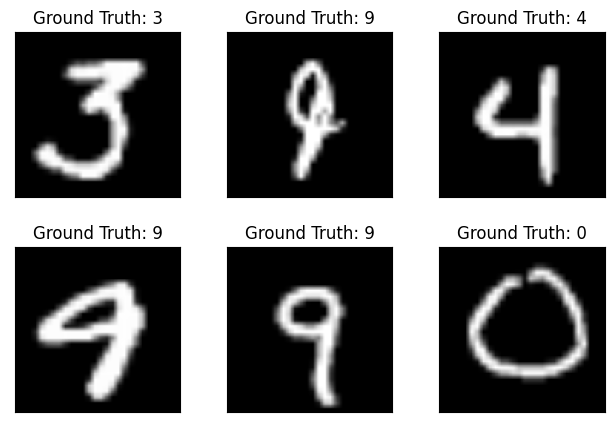

In [104]:
examples = enumerate(test_dataloader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets.shape)
print(example_data.shape)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

## 3. 构建AlexNet网络

根据AlexNet原文来构建网络，如下图所示：

![AlexNet架构](https://imgconvert.csdnimg.cn/aHR0cHM6Ly9zczAuYmRzdGF0aWMuY29tLzcwY0Z2SFNoX1ExWW54R2twb1dLMUhGNmhoeS9pdC91PTE1NTQ3NzYzOTUsMzU0MDU4MzUwOSZmbT0yNiZncD0wLmpwZw?x-oss-process=image/format,png)

受到K210内存的限制，以下代码减少了参数量

In [105]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,6,kernel_size=11,stride=4,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(6,16,kernel_size=5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(16,32,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,32,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(800,128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128,32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(32,10)
        )
        
    def forward(self,x):
        x = self.features(x)
        x = x.view(-1,800)
        x = self.classifier(x)
        return x

## 4. 定义优化器和损失函数

In [106]:
net = AlexNet().to(device)
loss = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

## 5. 训练评估及可视化

### 5.1 精度评估

In [107]:

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

### 5.2 训练部分

In [108]:
#@save
def train(net, train_iter, test_iter, num_epochs, optimizer, loss, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    num_batches = len(train_iter)
    best_acc = 0
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        if test_acc > best_acc:
            torch.save(net,'best.pt')
            best_acc = test_acc
            print(f'best model saved, loss {train_l:.3f}, train acc {train_acc:.3f}, '
                  f'test acc {test_acc:.3f}')
        print(f'epoch {epoch}: loss {train_l:.3f}, train acc {train_acc:.3f}, '
              f'test acc {test_acc:.3f}')
    torch.save(net,'last.pt')

### 5.3 开始训练

In [109]:
train(net, train_dataloader, test_dataloader, epochs, optimizer, loss, device)

training on cuda
best model saved, loss 0.895, train acc 0.694, test acc 0.969
epoch 0: loss 0.895, train acc 0.694, test acc 0.969
best model saved, loss 0.289, train acc 0.917, test acc 0.980
epoch 1: loss 0.289, train acc 0.917, test acc 0.980
best model saved, loss 0.211, train acc 0.943, test acc 0.985
epoch 2: loss 0.211, train acc 0.943, test acc 0.985
best model saved, loss 0.173, train acc 0.955, test acc 0.988
epoch 3: loss 0.173, train acc 0.955, test acc 0.988
best model saved, loss 0.151, train acc 0.962, test acc 0.988
epoch 4: loss 0.151, train acc 0.962, test acc 0.988


## 6. PyTorch模型导出为ONNX格式

In [110]:
model = torch.load('best.pt').to(device)
model.eval()
dummy_input = torch.randn(1, 1, 224, 224, device=device)
torch.onnx.export(model, dummy_input, 'AlexNet_Minist.onnx', verbose=True)

Exported graph: graph(%input.1 : Float(1, 1, 224, 224, strides=[50176, 50176, 224, 1], requires_grad=0, device=cuda:0),
      %features.0.weight : Float(6, 1, 11, 11, strides=[121, 121, 11, 1], requires_grad=1, device=cuda:0),
      %features.0.bias : Float(6, strides=[1], requires_grad=1, device=cuda:0),
      %features.3.weight : Float(16, 6, 5, 5, strides=[150, 25, 5, 1], requires_grad=1, device=cuda:0),
      %features.3.bias : Float(16, strides=[1], requires_grad=1, device=cuda:0),
      %features.6.weight : Float(32, 16, 3, 3, strides=[144, 9, 3, 1], requires_grad=1, device=cuda:0),
      %features.6.bias : Float(32, strides=[1], requires_grad=1, device=cuda:0),
      %features.8.weight : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cuda:0),
      %features.8.bias : Float(64, strides=[1], requires_grad=1, device=cuda:0),
      %features.10.weight : Float(32, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=1, device=cuda:0),
      %features.10.bias : Float(3

### 6.1 ONNX模型推理验证

In [111]:
## 模型结构验证
import onnx
onnx_model = onnx.load("AlexNet_Minist.onnx")
print(onnx.checker.check_model(onnx_model))

None


In [112]:
## 随机张量验证
import onnxruntime

ort_session = onnxruntime.InferenceSession("AlexNet_Minist.onnx")
    
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

input_data = torch.randn(1, 1, 224, 224)
ort_input = {ort_session.get_inputs()[0].name: to_numpy(input_data)}
ort_out = ort_session.run(None, ort_input)
torch_out = model(input_data.to(device))

print(ort_out)
print(to_numpy(torch_out))
print(np.testing.assert_allclose(to_numpy(torch_out), ort_out[0], rtol=1e-03, atol=1e-05))


[array([[-0.1976682 , -0.1111972 ,  0.20592648,  0.02630134, -0.28379026,
        -0.08314224,  0.04218328,  0.37901822,  0.35434434, -0.15570363]],
      dtype=float32)]
[[-0.19779569 -0.11125133  0.20591912  0.02646033 -0.2839472  -0.08310819
   0.04216652  0.37901378  0.35434315 -0.155742  ]]


AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 1 / 10 (10%)
Max absolute difference: 0.000159
Max relative difference: 0.00604514
 x: array([[-0.197796, -0.111251,  0.205919,  0.02646 , -0.283947, -0.083108,
         0.042167,  0.379014,  0.354343, -0.155742]], dtype=float32)
 y: array([[-0.197668, -0.111197,  0.205926,  0.026301, -0.28379 , -0.083142,
         0.042183,  0.379018,  0.354344, -0.155704]], dtype=float32)

tensor(3)
[array([[ -8.315117 ,  -4.0913353,  -5.9618816,  26.731266 , -15.836234 ,
         10.150007 , -10.068277 ,  -9.974022 ,   2.9120288,   2.7530017]],
      dtype=float32)]
[[ -8.315041   -4.0910797  -5.961559   26.7314    -15.836407   10.149984
  -10.068223   -9.973431    2.9121685   2.7526271]]
None


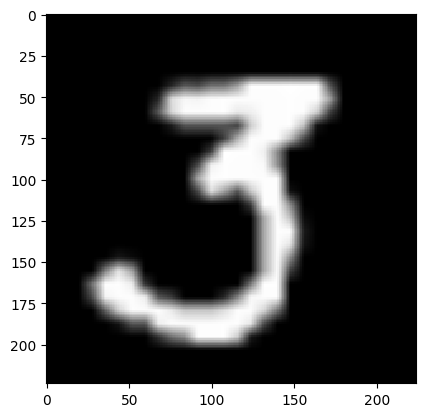

In [113]:
## 测试集图像验证
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')
input_data = example_data[0][0].view(-1,1,224,224)
ort_input = {ort_session.get_inputs()[0].name: to_numpy(input_data)}
ort_out = ort_session.run(None, ort_input)
torch_out = model(input_data.to(device))

print(example_targets[0])
print(ort_out)
print(to_numpy(torch_out))
print(np.testing.assert_allclose(to_numpy(torch_out), ort_out[0], rtol=1e-03, atol=1e-05))

## 7. ONNX模型导出为KModel格式

In [114]:
import nncase
import onnxsim
import os

def parse_model_input_output(model_file):
    onnx_model = onnx.load(model_file)
    input_all = [node.name for node in onnx_model.graph.input]
    input_initializer = [node.name for node in onnx_model.graph.initializer]
    input_names = list(set(input_all) - set(input_initializer))
    input_tensors = [node for node in onnx_model.graph.input if node.name in input_names]

    # input
    inputs = []
    for _, e in enumerate(input_tensors):
        onnx_type = e.type.tensor_type
        input_dict = {}
        input_dict['name'] = e.name
        input_dict['dtype'] = onnx.mapping.TENSOR_TYPE_TO_NP_TYPE[onnx_type.elem_type]
        input_dict['shape'] = [(i.dim_value if i.dim_value != 0 else d) for i, d in zip(
            onnx_type.shape.dim, [1, 3, 224, 224])]
        inputs.append(input_dict)

    return onnx_model, inputs

def onnx_simplify(model_file):
    onnx_model, inputs = parse_model_input_output(model_file)
    onnx_model = onnx.shape_inference.infer_shapes(onnx_model)
    input_shapes = {}
    for input in inputs:
        input_shapes[input['name']] = input['shape']

    onnx_model, check = onnxsim.simplify(onnx_model, overwrite_input_shapes=input_shapes)
    assert check, "Simplified ONNX model could not be validated"

    model_file = os.path.join(os.path.dirname(model_file), 'simplified.onnx')
    onnx.save_model(onnx_model, model_file)
    return model_file

def read_model_file(model_file):
    with open(model_file, 'rb') as f:
        model_content = f.read()
    return model_content

# onnx simplify
model_file = onnx_simplify("AlexNet_Minist.onnx")

# compile_options
compile_options = nncase.CompileOptions()
compile_options.target = 'k210'
compile_options.dump_ir = True
compile_options.dump_asm = True
compile_options.dump_dir = 'tmp'

# compiler
compiler = nncase.Compiler(compile_options)

# import_options
import_options = nncase.ImportOptions()

# import
model_content = read_model_file(model_file)
compiler.import_onnx(model_content, import_options)

# compile
compiler.compile()

# kmodel
kmodel = compiler.gencode_tobytes()
name = os.path.basename(model_file).split(".")[0]
with open(f'{name}.kmodel', 'wb') as f:
    f.write(kmodel)

1. Import graph...
2. Optimize target independent...
3. Optimize target dependent...
5. Optimize target dependent after quantization...
6. Optimize modules...
7.1. Merge module regions...
7.2. Optimize buffer fusion...
7.3. Optimize target dependent after buffer fusion...
8. Generate code...
WARN: Cannot find a decompiler for section .rdata
WARN: Cannot find a decompiler for section .text

SUMMARY
INPUTS
0	input.1	f32[1,1,224,224]
OUTPUTS
0	36	f32[1,10]

MEMORY USAGES
.input	 196.00 KB	(200704 B)
.output	  40.00 B	(40 B)
.data	 136.69 KB	(139968 B)
MODEL	 596.80 KB	(611120 B)
TOTAL	 929.52 KB	(951832 B)


### 7.1 KModel模型推理验证